<a href="https://colab.research.google.com/github/edgeofchaos42/mesa_tutorial/blob/main/MesaTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mesa --quiet


     |████████████████████████████████| 2.5 MB 13.5 MB/s 
     |████████████████████████████████| 596 kB 55.0 MB/s 
     |████████████████████████████████| 64 kB 2.2 MB/s 


In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunner

# For jupyter notebook add the following line:
%matplotlib inline

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [3]:
fixed_params = {"width": 10,
               "height": 10}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=2,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  # Remove the CWD from sys.path while we load stuff.
98it [00:24,  4.00it/s]


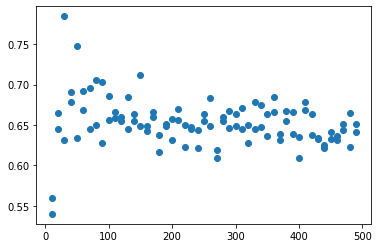

In [4]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)

In [10]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

NameError: ignored

In [6]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head(10)

NameError: ignored

In [7]:
end_wealth = agent_wealth.xs(15, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

NameError: ignored

In [8]:
one_agent_wealth = agent_wealth.xs(3, level="AgentID")
one_agent_wealth.Wealth.plot()

NameError: ignored

In [9]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

NameError: ignored